In [10]:
# Importing libraries 
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import glob
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

In [11]:
#  Setting up the device that will be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


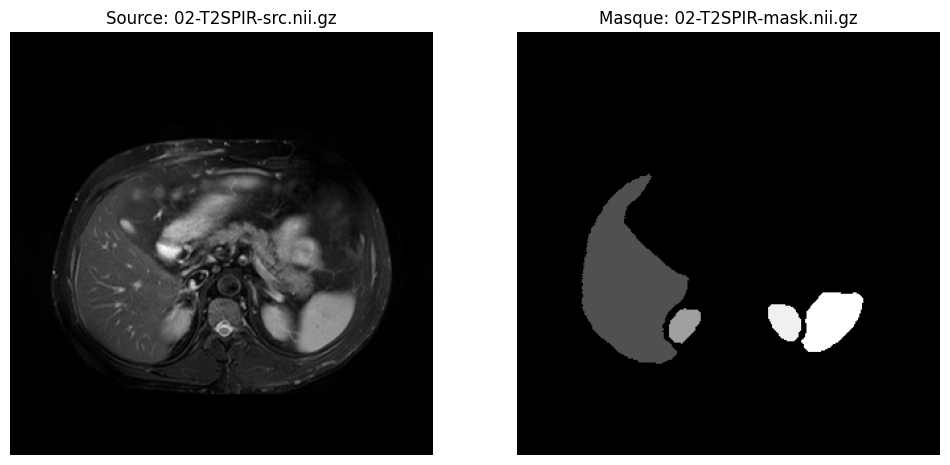

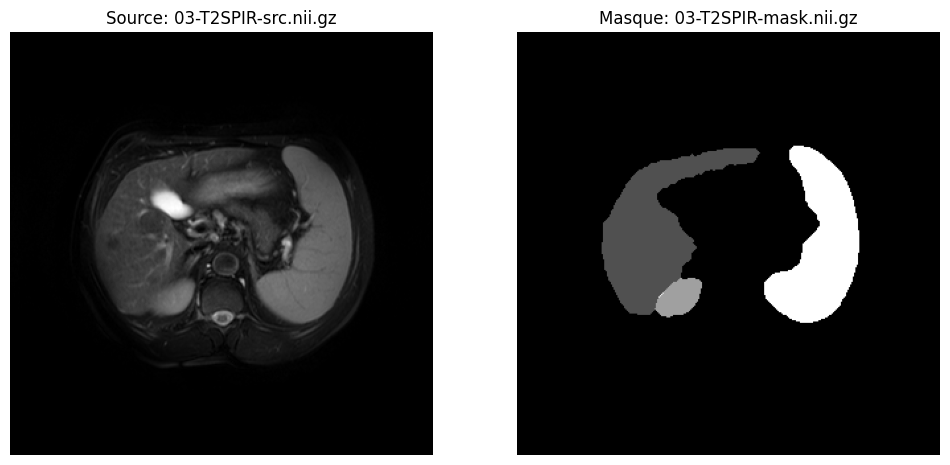

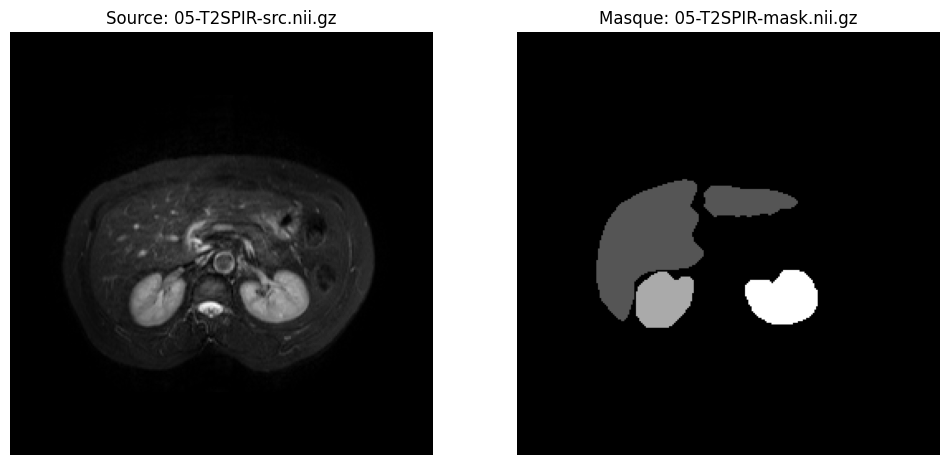

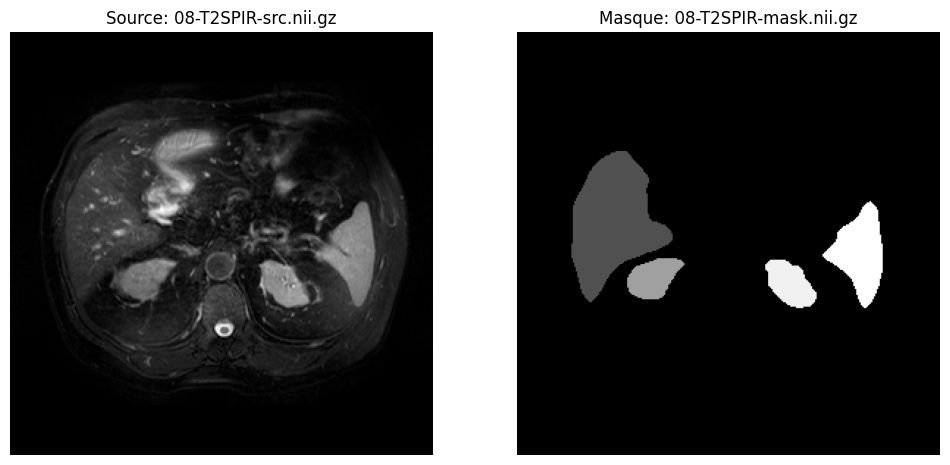

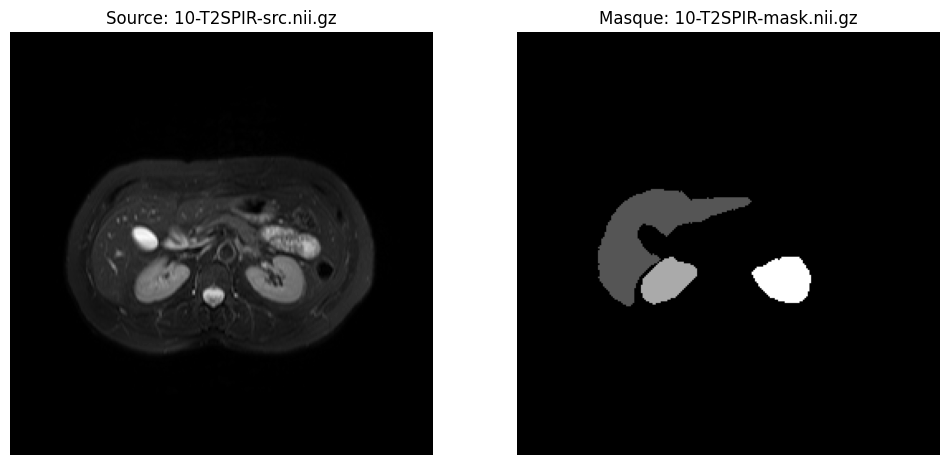

float64
[0. 1. 2. 3. 4.]


In [12]:
#Affichage des données
# Spécifiez le chemin du dossier contenant les fichiers .nii.gz
folder_path = 'CHAOS-MRT2'

# Lister tous les fichiers dans le dossier
files = os.listdir(folder_path)

# Séparer les fichiers source et masque à partir de "02"
src_files = sorted([f for f in files if f.endswith('-src.nii.gz') and '02' <= f[:2] <= '10'])
mask_files = sorted([f for f in files if f.endswith('-mask.nii.gz') and '02' <= f[:2] <= '10'])

# Vérifier que le nombre de fichiers source et masque correspond
assert len(src_files) == len(mask_files), "Le nombre de fichiers source et masque ne correspond pas!"

# Afficher les 10 premiers fichiers source et masque
for i in range(min(10, len(src_files))):
    src_file = src_files[i]
    mask_file = mask_files[i]
    
    # Obtenir les chemins complets des fichiers
    src_path = os.path.join(folder_path, src_file)
    mask_path = os.path.join(folder_path, mask_file)
    
    # Charger les images source et masque
    src_img = nib.load(src_path).get_fdata()
    mask_img = nib.load(mask_path).get_fdata()
    
    # Extraire une coupe 2D au milieu de l'axe z
    slice_z_src = src_img[:, :, src_img.shape[2] // 2]
    slice_z_mask = mask_img[:, :, mask_img.shape[2] // 2]
    
    # Créer une figure pour afficher les deux images côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Afficher l'image source
    axes[0].imshow(slice_z_src.T, cmap='gray', origin='lower')
    axes[0].set_title(f'Source: {src_file}')
    axes[0].axis('off')
    
    # Afficher l'image masque
    axes[1].imshow(slice_z_mask.T, cmap='gray', origin='lower')
    axes[1].set_title(f'Masque: {mask_file}')
    axes[1].axis('off')
    
    # Afficher la figure
    plt.show()

# Test pour verifier si les images sont de quel format (float64 et 5 valeurs pour les masques)

folder_path_normalized='CHAOS-MRT2-NORMALIZED'
filesBis = os.listdir(folder_path_normalized)

nii_file = filesBis[0]  # ou .nii si vous avez des fichiers non compressés
src_path = os.path.join(folder_path_normalized, nii_file)
nii_img = nib.load(src_path)

# Extraire les données sous forme de tableau NumPy
mask_array = nii_img.get_fdata()

# Vérifier le type des données
print(mask_array.dtype)

# Vérifier les valeurs uniques dans le masque
print(np.unique(mask_array))


In [4]:
# Code pour convertir les fichiers en bon format.
''''
# Dossiers d'entrée et de sortie
input_folder = 'CHAOS-MRT2'  # Chemin vers votre dossier avec les fichiers NIfTI
output_folder = 'CHAOS-MRT2-NORMALIZED'     # Chemin vers le dossier de sortie

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Fonction pour normaliser les fichiers sources
def normalize_image(image_array):
    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Fonction pour convertir les masques en classes entières
def convert_mask(mask_array):
    mask_array_int = np.zeros_like(mask_array, dtype=np.uint8)
    mask_array_int[mask_array == 0] = 0  # Arrière-plan
    mask_array_int[mask_array == 80] = 1  # Classe 1
    mask_array_int[mask_array == 160] = 2  # Classe 2
    mask_array_int[mask_array == 240] = 3  # Classe 3
    mask_array_int[mask_array == 255] = 4  # Classe 4 (à vérifier)
    return mask_array_int

# Parcourir tous les fichiers du dossier
for filename in os.listdir(input_folder):
    if filename.endswith('-src.nii.gz'):  # Fichier source (image)
        # Charger le fichier source
        src_path = os.path.join(input_folder, filename)
        src_img = nib.load(src_path)
        src_array = src_img.get_fdata()

        # Normaliser l'image A voir s'il faut le garder.
        src_array_norm = normalize_image(src_array).astype(np.float32)

        # Sauvegarder l'image normalisée
        output_path = os.path.join(output_folder, filename)
        new_src_img = nib.Nifti1Image(src_array_norm, affine=src_img.affine)
        nib.save(new_src_img, output_path)
        print(f"Image source normalisée sauvegardée : {output_path}")

    elif filename.endswith('-mask.nii.gz'):  # Fichier masque
        # Charger le fichier masque
        mask_path = os.path.join(input_folder, filename)
        mask_img = nib.load(mask_path)
        mask_array = mask_img.get_fdata()

        # Convertir les masques en classes entières
        mask_array_int = convert_mask(mask_array)

        # Sauvegarder le masque converti
        output_path = os.path.join(output_folder, filename)
        new_mask_img = nib.Nifti1Image(mask_array_int, affine=mask_img.affine)
        nib.save(new_mask_img, output_path)
        print(f"Masque converti sauvegardé : {output_path}")
'''

'\'\n# Dossiers d\'entrée et de sortie\ninput_folder = \'CHAOS-MRT2\'  # Chemin vers votre dossier avec les fichiers NIfTI\noutput_folder = \'CHAOS-MRT2-NORMALIZED\'     # Chemin vers le dossier de sortie\n\n# Créer le dossier de sortie s\'il n\'existe pas\nif not os.path.exists(output_folder):\n    os.makedirs(output_folder)\n\n# Fonction pour normaliser les fichiers sources\ndef normalize_image(image_array):\n    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))\n\n# Fonction pour convertir les masques en classes entières\ndef convert_mask(mask_array):\n    mask_array_int = np.zeros_like(mask_array, dtype=np.uint8)\n    mask_array_int[mask_array == 0] = 0  # Arrière-plan\n    mask_array_int[mask_array == 80] = 1  # Classe 1\n    mask_array_int[mask_array == 160] = 2  # Classe 2\n    mask_array_int[mask_array == 240] = 3  # Classe 3\n    mask_array_int[mask_array == 255] = 4  # Classe 4 (à vérifier)\n    return mask_array_int\n\n# Parcourir tous 

Tailles des fichiers sources (src) :
02-T2SPIR-src.nii.gz : (320, 320, 26)
03-T2SPIR-src.nii.gz : (320, 320, 30)
05-T2SPIR-src.nii.gz : (256, 256, 30)
08-T2SPIR-src.nii.gz : (288, 288, 32)
10-T2SPIR-src.nii.gz : (256, 256, 36)
13-T2SPIR-src.nii.gz : (320, 320, 30)
15-T2SPIR-src.nii.gz : (256, 256, 26)
19-T2SPIR-src.nii.gz : (320, 320, 30)
20-T2SPIR-src.nii.gz : (320, 320, 26)
21-T2SPIR-src.nii.gz : (256, 256, 31)
22-T2SPIR-src.nii.gz : (256, 256, 33)
31-T2SPIR-src.nii.gz : (256, 256, 29)
32-T2SPIR-src.nii.gz : (256, 256, 39)
33-T2SPIR-src.nii.gz : (256, 256, 29)
34-T2SPIR-src.nii.gz : (256, 256, 30)
36-T2SPIR-src.nii.gz : (256, 256, 38)
37-T2SPIR-src.nii.gz : (256, 256, 32)
38-T2SPIR-src.nii.gz : (320, 320, 34)
39-T2SPIR-src.nii.gz : (256, 256, 26)

Tailles des fichiers masques (mask) :
02-T2SPIR-mask.nii.gz : (320, 320, 26)
03-T2SPIR-mask.nii.gz : (320, 320, 30)
05-T2SPIR-mask.nii.gz : (256, 256, 30)
08-T2SPIR-mask.nii.gz : (288, 288, 32)
10-T2SPIR-mask.nii.gz : (256, 256, 36)
13-T2SP

In [13]:


# Chemin vers le dossier contenant les fichiers CHAOS
chaos_dir = 'CHAOS-MRT2-NORMALIZED'

# Récupérer tous les fichiers .nii.gz
all_src_files = sorted(glob.glob(os.path.join(chaos_dir, '*-src.nii.gz')))
all_mask_files = sorted(glob.glob(os.path.join(chaos_dir, '*-mask.nii.gz')))

# Vérification de la correspondance des fichiers source et masque
assert len(all_src_files) == len(all_mask_files), "Le nombre de fichiers source et masque ne correspond pas!"

# Taille cible (à adapter selon vos besoins)
target_shape = (256, 256, 32)

# Définition du Dataset personnalisé pour charger les .nii.gz à la demande
class LazyNiiDataset(Dataset):
    def __init__(self, src_files, mask_files, target_shape):
        self.src_files = src_files
        self.mask_files = mask_files
        self.target_shape = target_shape

    def __len__(self):
        return len(self.src_files)

    def __getitem__(self, idx):
        # Charger le fichier source et le fichier masque
        src_tensor = self.load_and_resize(self.src_files[idx])
        mask_tensor = self.load_and_resize(self.mask_files[idx])
        
        return src_tensor, mask_tensor

    def load_and_resize(self, file_path):
        nii = nib.load(file_path)
        img_data = nii.get_fdata()
        tensor_data = torch.tensor(img_data, dtype=torch.float32)

        # Redimensionnement à la taille cible
        tensor_data = tensor_data.unsqueeze(0).unsqueeze(0)  # Ajouter les dimensions batch et channel
        resized_tensor = F.interpolate(tensor_data, size=self.target_shape, mode='trilinear', align_corners=False)
        return resized_tensor.squeeze()  # Supprimer les dimensions supplémentaires

# Division des données en ensembles d'entraînement, validation et test
train_src, temp_src, train_mask, temp_mask = train_test_split(all_src_files, all_mask_files, test_size=0.2, random_state=42)
val_prop = 0.5  # Pour séparer temp en validation et test
val_src, test_src, val_mask, test_mask = train_test_split(temp_src, temp_mask, test_size=val_prop, random_state=42)

# Créer les datasets
train_dataset = LazyNiiDataset(train_src, train_mask, target_shape)
val_dataset = LazyNiiDataset(val_src, val_mask, target_shape)
test_dataset = LazyNiiDataset(test_src, test_mask, target_shape)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Afficher la forme d'un batch pour vérifier
for x, y in train_loader:
    print(f'Batch X shape: {x.shape}, Batch Y shape: {y.shape}')
    break


Batch X shape: torch.Size([1, 256, 256, 32]), Batch Y shape: torch.Size([1, 256, 256, 32])


In [14]:
# Architecture U-net Classique
#On peut ajouter du dropout a la fin pour essayer
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5):
        super(UNet3D, self).__init__()
        
        # Contracting path
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)

        # Bottleneck
        self.bottleneck = self.contract_block(512, 1024)
        # Expanding path
        self.dec4 = self.expand_block(1536, 512)
        self.dec3 = self.expand_block(768, 256)
        self.dec2 = self.expand_block(384, 128)
        self.dec1 = self.expand_block(192, 64)

        # Output layer
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def up_concat(self, x1, x2):
        """
        Fonction pour le chemin de décodage (concaténation avec skip connections)
        """
        # Redimensionner x1 pour qu'il corresponde à la taille de x2
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='trilinear', align_corners=True)
        return torch.cat([x1, x2], dim=1)

    
    def forward(self, x):
        # Encode
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decode 

        dec4 = self.up_concat(bottleneck,enc4)
        dec4 = self.dec4(dec4)
        
        dec3 = self.up_concat(dec4,enc3)
        dec3 = self.dec3(dec3)
        
        dec2 = self.up_concat(dec3,enc2)
        dec2 = self.dec2(dec2)

        dec1 = self.up_concat(dec2,enc1)
        dec1 = self.dec1(dec1)
        return self.final_conv(dec1)

model = UNet3D()

# Summary of the model
#summary(model, input_size=(1,128, 128,128)) # (channels, depth, height, width)


In [15]:
# Architecture U-net Avec Augmentation
#On peut ajouter du dropout a la fin pour essayer
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv3d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out
        
        
        

class UNetAug3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5,n_coefficients=3):
        super(UNetAug3D, self).__init__()
        
        self.MaxPool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Contracting path
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)
        self.enc5 = self.contract_block(512, 1024)

        
        # Expanding path
        self.dec5 = self.expand_block(1024, 512)
        self.att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.conv5=self.contract_block(1024,512)

        self.dec4 = self.expand_block(512, 256)
        self.att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.conv4=self.contract_block(512, 256)

        self.dec3 = self.expand_block(256, 128)
        self.att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.conv3=self.contract_block(256, 128)

        self.dec2 = self.expand_block(128, 64)
        self.att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.conv2=self.contract_block(128, 64)

        # Output layer
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1, stride=1, padding=0)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3,stride=1, padding=1,bias=True),            
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3,stride=1, padding=1,bias=True),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
    # Encode
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.MaxPool(enc1))
        enc3 = self.enc3(self.MaxPool(enc2))
        enc4 = self.enc4(self.MaxPool(enc3))
        enc5 = self.enc5(self.MaxPool(enc4))

        # Decode 
        dec5 = self.dec5(enc5)
        att4 = self.att5(gate=dec5, skip_connection=enc4)
        dec5 = torch.cat((att4, dec5), dim=1)
        dec5 = self.conv5(dec5)

        dec4 = self.dec4(dec5)
        att3 = self.att4(gate=dec4, skip_connection=enc3)
        dec4 = torch.cat((att3, dec4), dim=1)
        dec4 = self.conv4(dec4)

        dec3 = self.dec3(dec4)
        att2 = self.att3(gate=dec3, skip_connection=enc2)  
        dec3 = torch.cat((att2, dec3), dim=1)
        dec3 = self.conv3(dec3)  

        dec2 = self.dec2(dec3)
        att1 = self.att2(gate=dec2, skip_connection=enc1)  
        dec2 = torch.cat((att1, dec2), dim=1)
        dec2 = self.conv2(dec2)  
        
        return self.final_conv(dec2)

model2 = UNetAug3D()

# Summary of the model
#summary(model2, input_size=(1,128, 128,128)) # (channels, depth, height, width)
#summary a essayer

In [16]:

# Exemple de pondération des classes si la classe 0 est dominante
class_weights = torch.tensor([0.1, 10.0, 15.0, 15.0, 10.0])  # Ajuste les valeurs selon la distribution des classes réelles

# Appliquer la pondération dans la perte
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [9]:
# Load the weights saved 
checkpoint_path = 'model_weights49.pth'
model.load_state_dict(torch.load(checkpoint_path))

/tmp/ipykernel_14029/3099520826.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


<All keys matched successfully>

In [1]:
n_epochs = 5  # nombre d'époques d'entraînement

# Fonction d'entraînement modifiée
def training(model, criterion, optimizer, train_loader, val_loader):
    train_losses, valid_losses = [], []
    valid_loss_min = np.inf
    i = 0
    
    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0

        # Entraînement
        model.train()
        for data, label in train_loader:
            data = data.unsqueeze(1).to(device)  # Ajouter la dimension des canaux
            label = label.to(device).long()

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            # Sauvegarde de l'évolution toutes les 15 itérations
            if i % 15 == 0:
                softmax_output = F.softmax(output, dim=1)
                predicted_mask = torch.argmax(softmax_output, dim=1).cpu().squeeze().numpy().astype(np.int32)
                predicted_nii = nib.Nifti1Image(predicted_mask, np.eye(4))
                nib.save(predicted_nii, f"Essais_unet_aug/predicted_mask_train0bisbistest{i//15}.nii.gz")
            i += 1

        # Validation
        model.eval()
        for data, label in val_loader:
            data = data.unsqueeze(1).to(device)  # Ajouter la dimension des canaux
            label = label.to(device).long()

            with torch.no_grad():
                output = model(data)
            loss = criterion(output, label)
            valid_loss += loss.item() * data.size(0)

        # Calcul des pertes moyennes
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        # Sauvegarder le modèle si la perte de validation a diminué
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss

    return train_losses, valid_losses

# Exécuter l'entraînement
train_losses, valid_losses = training(model, criterion, optimizer, train_loader, val_loader)

# Exécuter l'entraînement


NameError: name 'model' is not defined

In [25]:
train_losses, valid_losses = training(model, criterion, optimizer, train_loader, val_loader)


NotImplementedError: Got 4D input, but trilinear mode needs 5D input

In [11]:
#Sauvegarde des poids du modèle : 
# Chemin où tu veux sauvegarder les poids (par exemple, dans un fichier .pth)
checkpoint_weights_path = 'model_weights49.pth'

# Sauvegarder les poids du modèle
torch.save(model.state_dict(), checkpoint_weights_path)
print(f"Model weights saved in  {checkpoint_weights_path}")

#Sauvegarde de tous le modèle : 
# Sauvegarder tout le modèle (pas uniquement les poids)
checkpoint_model_path = 'full_model49.pth'
torch.save(model, checkpoint_model_path)
print(f"Model saved in {checkpoint_model_path}")

# Charger tout le modèle
#model = torch.load('full_model.pth')
#model.eval()  # Ne pas oublier de passer en mode évaluation pour les prédictions


Model weights saved in  model_weights49.pth
Model saved in full_model49.pth


In [ ]:
print(train_losses)
print(valid_losses)

[0.34065497616926826, 0.33185494343439736, 0.3375903993844986, 0.3146134992440542, 0.31206198732058205, 0.29047996799151105, 0.27897928953170775, 0.27291470070679985, 0.26812743246555326, 0.2624181648095449]
[0.4354070797562599, 0.3891746401786804, 0.3669961094856262, 0.3351314663887024, 0.3333541825413704, 0.3362499698996544, 0.33487100154161453, 0.330795556306839, 0.3511948697268963, 0.3589772433042526]


In [9]:
#FAIRE print les noms des fichiers pour plus de clarté 
def save_predicted_mask(model, input_tensor, output_path):
    """
    Sauvegarde le masque prédit par le modèle sous forme de fichier .nii.gz
    
    :param model: le modèle UNet3D entraîné
    :param input_tensor: tensor d'entrée de forme [1, 1, depth, height, width]
    :param output_path: chemin de sauvegarde du fichier de masque prédictif
    """
    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        # Prédire avec le modèle
        output = model(input_tensor.unsqueeze(0).unsqueeze(0))  # Ajouter batch dim
        # Sortie du modèle [batch_size, n_classes, depth, height, width]
        # Prendre l'argmax pour obtenir la classe la plus probable
        #print(f"Valeurs min/max de l'output avant argmax: {output.min()}/{output.max()}")
        softmax_output = F.softmax(output, dim=1)
        #print("Softmax Output:", softmax_output[0].cpu().detach().numpy())
        predicted_mask = torch.argmax(softmax_output, dim=1).cpu().squeeze().numpy()

       
        # Convertir en int32 pour éviter les problèmes de compatibilité avec NIfTI
        predicted_mask = predicted_mask.astype(np.int32)
        # Créer un fichier NIfTI pour le masque prédit
        predicted_nii = nib.Nifti1Image(predicted_mask, np.eye(4))  # Créer une matrice d'identité pour l'affine
        nib.save(predicted_nii, output_path)
        print(f"Fichier de masque prédit sauvegardé à {output_path}")
        # Vérifier la distribution des classes dans le masque prédit
        unique_classes, class_counts = np.unique(predicted_mask, return_counts=True)
        print(f"Classes prédites: {unique_classes}")
        print(f"Nombre de pixels par classe: {class_counts}")

def save_predicted_mask_all(model, input_tensor, output_path):
    """
    Sauvegarde le masque prédit par le modèle sous forme de fichier .nii.gz
    
    :param model: le modèle UNet3D entraîné
    :param input_tensor: tensor d'entrée de forme [1, 1, depth, height, width]
    :param output_path: chemin de sauvegarde du fichier de masque prédictif
    """
    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        # Prédire avec le modèle
        for i in range(len(input_tensor)) :
            output = model(input_tensor[i].unsqueeze(0).unsqueeze(0))  # Ajouter batch dim
            # Sortie du modèle [batch_size, n_classes, depth, height, width]
            # Prendre l'argmax pour obtenir la classe la plus probable
            print(f"Valeurs min/max de l'output avant argmax: {output.min()}/{output.max()}")
            predicted_mask = torch.argmax(output, dim=1).cpu().squeeze().numpy()
            # Convertir en int32 pour éviter les problèmes de compatibilité avec NIfTI
            predicted_mask = predicted_mask.astype(np.int32)
            # Créer un fichier NIfTI pour le masque prédit
            predicted_nii = nib.Nifti1Image(predicted_mask, np.eye(4))  # Créer une matrice d'identité pour l'affine
            nib.save(predicted_nii, output_path+str(i)+".nii.gz")
            print(f"Fichier de masque prédit sauvegardé à {output_path}")


# Exemple d'utilisation
# input_tensor est une image unique à prédire
input_tensor = x_test[0]  # Par exemple, on prend la première image du train
output_path = "predicted_mask_test0.nii.gz"
save_predicted_mask(model, input_tensor, output_path)


# Exemple d'utilisation
# input_tensor est une image unique à prédire
#output_path = "predicted_mask_train"
#save_predicted_mask_all(model, x_train, output_path)

Fichier de masque prédit sauvegardé à predicted_mask_test0.nii.gz
Classes prédites: [0 1 2 3 4]
Nombre de pixels par classe: [1722041  234242   60487   51578   28804]


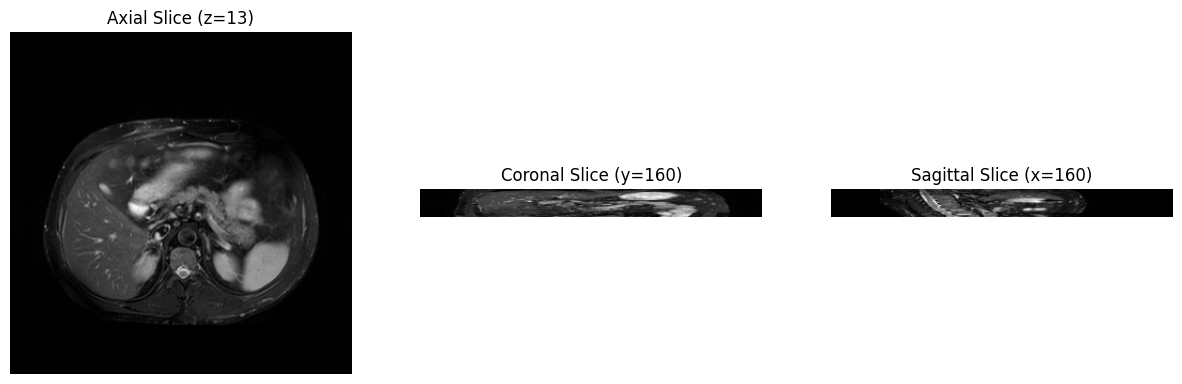

In [21]:
def display_nii_slices(nii_file, slice_indices=None):
    """
    Affiche des coupes axiale, coronale et sagittale d'un fichier NIfTI.
    
    :param nii_file: Chemin vers le fichier NIfTI (.nii ou .nii.gz)
    :param slice_indices: Tuple avec les indices des coupes (axiale, coronale, sagittale), 
                          si None, on prend les coupes du milieu.
    """
    # Charger le fichier NIfTI
    nii_data = nib.load(nii_file)
    img_data = nii_data.get_fdata()

    # Si les indices de coupes ne sont pas fournis, prendre les coupes du milieu
    if slice_indices is None:
        slice_indices = (img_data.shape[2] // 2,  # Axial (z)
                         img_data.shape[1] // 2,  # Coronal (y)
                         img_data.shape[0] // 2)  # Sagittal (x)
    
    # Extraire les coupes
    axial_slice = img_data[:, :, slice_indices[0]]  # Axe axial (z)
    coronal_slice = img_data[:, slice_indices[1], :]  # Axe coronal (y)
    sagittal_slice = img_data[slice_indices[2], :, :]  # Axe sagittal (x)

    # Afficher les coupes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(axial_slice.T, cmap='gray', origin='lower')
    axes[0].set_title(f'Axial Slice (z={slice_indices[0]})')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice.T, cmap='gray', origin='lower')
    axes[1].set_title(f'Coronal Slice (y={slice_indices[1]})')
    axes[1].axis('off')

    axes[2].imshow(sagittal_slice.T, cmap='gray', origin='lower')
    axes[2].set_title(f'Sagittal Slice (x={slice_indices[2]})')
    axes[2].axis('off')

    plt.show()

# Exemple d'utilisation :
nii_file_path = 'CHAOS-MRT2/02-T2SPIR-src.nii.gz'  # Chemin vers ton fichier .nii ou .nii.gz
display_nii_slices(nii_file_path)


In [1]:


# Fonction pour afficher les 32 tranches d'un tensor 3D redimensionné
def show_32_slices(tensor_3d):
    """
    tensor_3d: le tensor PyTorch 3D redimensionné à une taille [256, 256, 32]
    """
    tensor_np = tensor_3d.numpy()  # Convertir le tensor en numpy pour Matplotlib
    
    # Si les axes sont inversés, il faut peut-être transposer les dimensions (axes)
    tensor_np = np.transpose(tensor_np, (2, 1, 0))  # Réorganiser les axes si nécessaire
    
    # Assurez-vous que la dernière dimension a bien 32 tranches
    assert tensor_np.shape[0] == 32, "Le tensor ne contient pas 32 tranches!"

    # Création de la figure avec sous-graphiques
    num_cols = 8  # Par exemple, 8 colonnes
    num_rows = 4  # Car 8 colonnes x 4 lignes = 32 tranches
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    
    # Parcourir les 32 tranches
    for i in range(32):
        slice_2d = tensor_np[i, :, :]  # On sélectionne les tranches dans la première dimension

        # Trouver la position correspondante dans la grille de subplots
        row, col = divmod(i, num_cols)
        ax = axs[row, col]  # Sélectionner le subplot

        # Afficher l'image 2D de la tranche
        ax.imshow(slice_2d, cmap='gray')
        ax.set_title(f'Slice {i}')
        ax.axis('off')  # Désactiver les axes pour une meilleure visibilité

    # Ajuster l'espacement entre les subplots
    plt.tight_layout()
    plt.show()




# Afficher les 32 tranches de x_train[0]


# Afficher toutes les tranches de x_train[0] selon l'axe de profondeur (axis=0)

def display_all_slices(nii_file, axis=2, max_slices=32):
    """
    Affiche les slices d'un fichier NIfTI dans une grille de sous-plots.
    
    :param nii_file: Chemin vers le fichier NIfTI (.nii ou .nii.gz)
    :param axis: Axe selon lequel afficher les coupes (0: Sagittal, 1: Coronal, 2: Axial)
    :param max_slices: Nombre maximum de slices à afficher
    """
    # Charger le fichier NIfTI
    nii_data = nib.load(nii_file)
    img_data = nii_data.get_fdata()

    # Nombre de coupes dans l'axe spécifié
    num_slices = img_data.shape[axis]

    # Limiter le nombre de slices à afficher
    num_slices_to_display = min(num_slices, max_slices)

    # Calculer la disposition de la grille
    cols = int(np.ceil(np.sqrt(num_slices_to_display)))
    rows = int(np.ceil(num_slices_to_display / cols))

    # Créer la figure pour les sous-plots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    
    # Si le nombre de sous-plots est inférieur aux cases dans la grille
    axes = axes.flatten()

    # Afficher chaque slice dans un sous-plot
    for i in range(num_slices_to_display):
        if axis == 0:  # Sagittal
            slice_img = img_data[i, :, :]
        elif axis == 1:  # Coronal
            slice_img = img_data[:, i, :]
        elif axis == 2:  # Axial
            slice_img = img_data[:, :, i]

        axes[i].imshow(np.rot90(slice_img), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Slice {i+1}/{num_slices}')

    # Cacher les axes non utilisés si la grille est plus grande que le nombre de slices
    for ax in axes[num_slices_to_display:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
#modifier l'appel au masque en appelant directement x_train1
#show_32_slices(x_train[0]) # Image pas dans le bon sens
#show_32_slices(y_train[0]) # Image pas dans le bon sens
#display_all_slices('predicted_mask_train0test49.0.nii.gz', axis=2, max_slices=32)
#display_all_slices("predicted_mask_test0.nii.gz")
show_32_slices(y_val[0])



NameError: name 'y_val' is not defined

Text(0, 0.5, 'loss value')

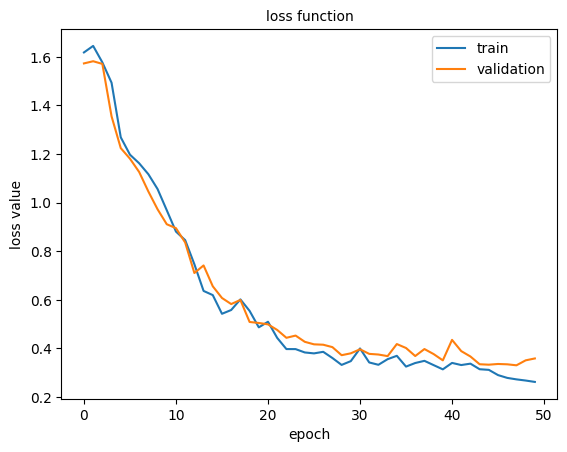

In [7]:
train_losses=[1.618106238047282, 1.6448826313018798, 1.5772061427434285, 1.4935248295466106, 1.2688742319742838, 1.1974346160888671, 1.162044930458069, 1.1170633912086487, 1.0560863852500915, 0.9687652309735616, 0.880884313583374, 0.8458095550537109, 0.7465836524963378, 0.6368123133977254, 0.6196435173352559, 0.5427512447039287, 0.5583034932613373, 0.6019951204458872, 0.5547107179959615, 0.48700920343399046,0.5099576532840728, 0.4435831030209859, 0.39759231011072793,0.3974313656489054, 0.3836345950762431, 0.3798316935698191, 0.38626033266385396, 0.3607888360818227, 0.33242214123408, 0.3479599634806315,0.4000725944836934, 0.3424849609533946, 0.3329223652680715, 0.35603811740875246, 0.3698268214861552, 0.3254921833674113, 0.34022545715173086, 0.34918142954508463, 0.33154579202334084, 0.3141287128130595,0.34065497616926826, 0.33185494343439736, 0.3375903993844986, 0.3146134992440542, 0.31206198732058205, 0.29047996799151105, 0.27897928953170775, 0.27291470070679985, 0.26812743246555326, 0.262418164809544]
valid_losses=[1.5729106664657593, 1.5818729102611542, 1.5709196627140045, 1.3552048206329346, 1.224452942609787, 1.1808674931526184, 1.1261485815048218, 1.0459165424108505, 0.9727327078580856, 0.9111852943897247, 0.8950274586677551, 0.8360584080219269, 0.7105303555727005, 0.741697296500206, 0.6558889001607895, 0.6077425479888916, 0.5828130841255188, 0.5996378138661385, 0.5091105252504349, 0.5049892961978912,0.4992702901363373, 0.4763250946998596, 0.4439574256539345,0.4530835524201393, 0.42743388563394547, 0.4170808047056198, 0.4155176654458046, 0.4055609032511711, 0.3723714053630829, 0.3800884932279587,0.39664435386657715, 0.37782634049654007, 0.3751765489578247, 0.36854980140924454, 0.4182021990418434, 0.4019945189356804, 0.36890845745801926, 0.39767052978277206, 0.3769936189055443, 0.3511225059628486,0.4354070797562599, 0.3891746401786804, 0.3669961094856262, 0.3351314663887024, 0.3333541825413704, 0.3362499698996544, 0.33487100154161453, 0.330795556306839, 0.3511948697268963, 0.3589772433042526]
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)


In [22]:


nii_file = 'predicted_mask_train0.nii.gz' # ou .nii si vous avez des fichiers non compressés
nii_img = nib.load(nii_file)

# Extraire les données sous forme de tableau NumPy
mask_array = nii_img.get_fdata()

# Vérifier le type des données
print(mask_array.dtype)

# Vérifier les valeurs uniques dans le masque
print(np.unique(mask_array))
# a faire l'évaluation


float64
[0.]


In [16]:
def get_all_prediction(model):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in zip(x_test,y_test):
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [17]:
targets, preds = get_all_prediction(UNet3D)  # comprendre comment fabriquer les loaders

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
"""'''n_epochs = 5 # number of epochs to train the model

def training(model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min =  np.inf  # set initial "min" to infinity ou a changer si on a deja un précésent
  i=0
  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
     
      for data, label in zip(x_train, y_train):
          #Adding the batch and the number of channels
          data = data.unsqueeze(0).unsqueeze(0)  # Shape: [batch_size, 1, depth, height, width]
          label = label.unsqueeze(0).to(device) #sensé mettre de la forme : [batch_size, depth, height, width
          label = label.long().to(device)
          
          optimizer.zero_grad() # clear the gradients of all optimized variables
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model

          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() * data.size(0) # update running training loss
          print(train_loss)
          
          #partie pour voir l'évolution
          if i%15==0 :
            softmax_output = F.softmax(output, dim=1)
            predicted_mask = torch.argmax(softmax_output, dim=1).cpu().squeeze().numpy()
              # Convertir en int32 pour éviter les problèmes de compatibilité avec NIfTI
            predicted_mask = predicted_mask.astype(np.int32)
              # Créer un fichier NIfTI pour le masque prédit
            predicted_nii = nib.Nifti1Image(predicted_mask, np.eye(4))  # Créer une matrice d'identité pour l'affine
            nib.save(predicted_nii, "Essais unet aug/predicted_mask_train0test"+str(i/15)+".nii.gz")
          i+=1

      # validate the model
      model.eval()
      for data, label in zip(x_test,y_test):
        #Adding the batch and the number of channels
        data = data.unsqueeze(0).unsqueeze(0)  # Shape: [batch_size, 1, depth, height, width]
        label = label.unsqueeze(0).to(device) #sensé mettre de la forme : [batch_size, depth, height, width
        label = label.long().to(device)
        
        with torch.no_grad():
            output = model(data)
        loss = criterion(output,label) #Si j'ai 3 channels, il faut modifier la taille de label à voir !
        valid_loss += loss.item() * data.size(0)

      # calculate average loss over an epoch
      train_loss /= len(x_train)
      valid_loss /= len(x_test)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses'''"""


"""# Traitement des données pour les mettre au bon format.
# Chemin vers votre dossier contenant les fichiers CHAOS
chaos_dir = 'CHAOS-MRT2-NORMALIZED'

# Récupérer tous les fichiers .nii.gz
all_src_files = sorted(glob.glob(os.path.join(chaos_dir, '*-src.nii.gz')))
all_mask_files = sorted(glob.glob(os.path.join(chaos_dir, '*-mask.nii.gz')))

# Vérification de la correspondance des fichiers src et mask
assert len(all_src_files) == len(all_mask_files), "Le nombre de fichiers source et masque ne correspond pas!"

# Fonction pour obtenir la taille d'un fichier .nii.gz
def get_nii_shape(file_path):
    nii = nib.load(file_path)
    return nii.shape

# Afficher les tailles des fichiers sources et masques
print("Tailles des fichiers sources (src) :")
for src_file in all_src_files:
    shape = get_nii_shape(src_file)
    print(f"{os.path.basename(src_file)} : {shape}")

print("\nTailles des fichiers masques (mask) :")
for mask_file in all_mask_files:
    shape = get_nii_shape(mask_file)
    print(f"{os.path.basename(mask_file)} : {shape}")

# Fonction pour charger les fichiers .nii.gz en tensors
def load_nii_to_tensor(file_path):
    nii = nib.load(file_path)
    img_data = nii.get_fdata()
    tensor_data = torch.tensor(img_data, dtype=torch.float32)
    return tensor_data

# Fonction pour redimensionner les images 3D à une taille cible (ex: [256, 256, 32])
def resize_tensor(tensor, target_shape):
    # torch.nn.functional.interpolate travaille sur des tensors de 4 dimensions (batch, channels, depth, height, width)
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # Ajouter des dimensions batch et channel
    resized_tensor = F.interpolate(tensor, size=target_shape, mode='trilinear', align_corners=False)
    return resized_tensor.squeeze()  # Supprimer les dimensions supplémentaires

# Taille cible (à adapter selon vos besoins)
target_shape = (256, 256, 32)

# Charger et redimensionner les données
src_data = [resize_tensor(load_nii_to_tensor(src), target_shape) for src in all_src_files]
mask_data = [resize_tensor(load_nii_to_tensor(mask), target_shape) for mask in all_mask_files]

valSize=0.1 # Proportion des données de validations
testSize=0.1 # Proportion des donées de test
trainSize=0.8 #Proportion des données d'entrainement
# Séparer les données en ensembles d'entraînement et de test (80% train, 20% test)
train_src, temp_src, train_mask, temp_mask = train_test_split(src_data, mask_data, test_size=valSize+testSize, random_state=42)
valProp=valSize/(valSize+testSize)
val_src,test_src,val_mask,test_mask=train_test_split(temp_src, temp_mask, test_size=1-valProp, random_state=42)
# Convertir en tensors PyTorch
x_train = torch.stack(train_src)  # Ensemble d'entraînement (inputs)
y_train = torch.stack(train_mask)  # Ensemble d'entraînement (labels)

x_test = torch.stack(test_src)  # Ensemble de test (inputs)
y_test = torch.stack(test_mask)  # Ensemble de test (labels)

x_val=torch.stack(val_src) # Ensemble de validation (inputs)
y_val=torch.stack(val_mask) # Ensemble de validation (labels)

# Afficher les formes finales des tensors
print(f'Train X shape: {x_train.shape}, Train Y shape: {y_train.shape}')
print(f'Test X shape: {x_train.shape}, Test Y shape: {y_train.shape}')
print(f'Validation X shape: {x_val.shape}, Validation Y shape: {y_val.shape}')

"""
